In [ ]:
from Bio.PDB import PDBParser
import networkx as nx

class Protein:
    def __init__(self, fileName, thresh):
        self.pdbFile = fileName
        self.eThresh = thresh
        self.struct = self.getStruct(self.pdbFile)
        self.graph, self.layers = \
            self.genGraph(self.struct, self.eThresh)
        
    def getStruct(self, pdbFile):
        parser = PDBParser(QUIET=True)
        structure = \
            parser.get_structure("protein", pdbFile)
        return(structure)
        
    def genGraph(self, structure, eThresh):
        nodes, layers = [], []
        for model in structure:
            for chain in model:
                atoms = []
                for residue in chain:
                    for atom in residue:
                        if atom.name=="CA":
                            atoms.append(atom)
                if len(atoms):
                    nodes.extend(atoms)
                    layers.append(len(atoms))
        edges = []
        for i in range(len(nodes)-1):
            for j in range(i+1, len(nodes)):
                dist = nodes[i]-nodes[j]
                if dist>0. and dist<=eThresh:
                    edges.append((i,j))
        g = nx.Graph(edges)
        return(g, layers)

    def getGraph(self):
        return(self.graph, self.layers)

In [ ]:
prot = Protein("data/fold_clock_bmal1_model_0.pdb", 7.)
g, layers = prot.getGraph()
l1, l2 = layers[0], layers[1]

In [10]:
def compute_khop_jaccard_matrix(graph, k):
    n = graph.number_of_nodes()
    nodes = list(graph.nodes)
    nodes.sort()
    # print(nodes)
    # node_index = {node: idx for idx, node in enumerate(nodes)}  # Mapping of nodes to indices
    # Step 1: Compute k-hop neighbors for all nodes
    khop_neighbors = {}
    for node in nodes:
        neighbors = nx.single_source_shortest_path_length(graph, node, cutoff=k)
        # print(neighbors)
        # for x in graph.neighbors(354): print(x)
        khop_neighbors[node] = set(neighbors.keys()) - {node}
        # print(khop_neighbors[node])
        # break
    # print(khop_neighbors)
    # Step 2: Initialize similarity matrix
    jaccard_matrix = np.zeros((n, n))
    # Step 3: Compute pairwise Jaccard similarity
    for i, u in enumerate(nodes):
        for j, v in enumerate(nodes):
            if i <= j:  # Compute for upper triangular matrix
                nu, nv = khop_neighbors[u], khop_neighbors[v]
                intersection = len(nu & nv)
                union = len(nu | nv)
                similarity = intersection / union if union > 0 else 0.0
                jaccard_matrix[i, j] = jaccard_matrix[j, i] = similarity
    # print(jaccard_matrix[:10])
    return jaccard_matrix

def scale(Y):
    # Ensure Y is a dense numpy array
    # Y = np.array(Y)
    # Exclude diagonal elements
    Y_no_diag = Y.copy()
    np.fill_diagonal(Y_no_diag, 0)
    # Row-wise min-max normalization
    # min_vals = np.min(Y_no_diag, axis=1, keepdims=True)
    # max_vals = np.max(Y_no_diag, axis=1, keepdims=True)
    # delta = max_vals - min_vals
    # # Handle rows where min == max (all values are identical)
    # delta[delta == 0] = 1
    # Y_rescaled = (Y_no_diag - min_vals) / delta
    # Normalize by the maximum row sum
    row_sums = np.sum(Y_no_diag, axis=1, keepdims=True)
    max_row_sum = np.max(row_sums)
    Y_normalized = Y_no_diag / max_row_sum
    return Y_normalized

def standardize(matrix):
    return (matrix - matrix.mean()) / matrix.std()

# AMats = []
# for k in range(1, 4):
k = 2
print("k:",k)
overlapl1 = scale(compute_khop_jaccard_matrix(l1g, k))
overlapl2 = scale(compute_khop_jaccard_matrix(l2g, k))

k: 2


Epoch [1/10], Train Loss: 0.7996, Val Loss: 0.7332
Epoch [2/10], Train Loss: 0.7096, Val Loss: 0.7085
Epoch [3/10], Train Loss: 0.7041, Val Loss: 0.7059
Epoch [4/10], Train Loss: 0.7035, Val Loss: 0.7048
Epoch [5/10], Train Loss: 0.7035, Val Loss: 0.7048
Epoch [6/10], Train Loss: 0.7029, Val Loss: 0.7045
Epoch [7/10], Train Loss: 0.7031, Val Loss: 0.7047
Epoch [8/10], Train Loss: 0.7031, Val Loss: 0.7045
Epoch [9/10], Train Loss: 0.7028, Val Loss: 0.7041
Epoch [10/10], Train Loss: 0.7026, Val Loss: 0.7044


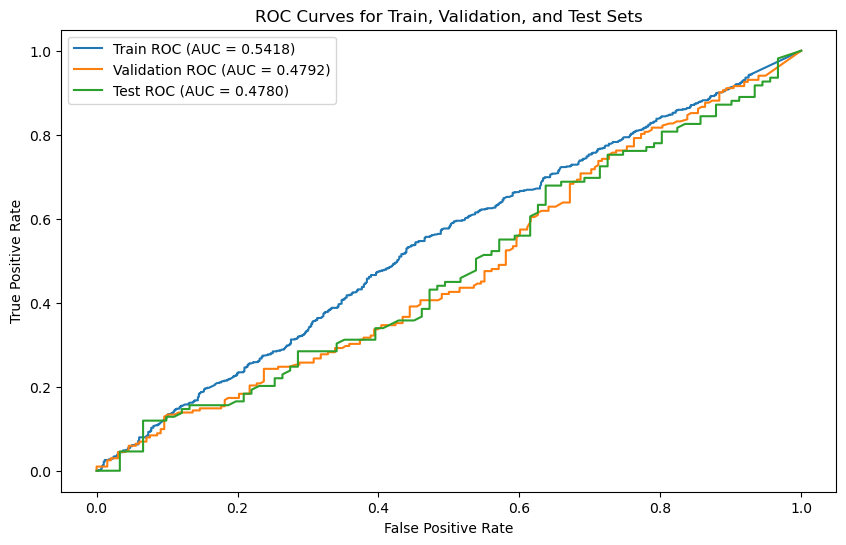

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
import numpy as np
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
rng = np.random.RandomState(42)

# Custom dataset for multiple graph pairs
class GraphPairDataset(Dataset):
    def __init__(self, graph_pairs):
        self.graph_pairs = graph_pairs

    def __len__(self):
        return len(self.graph_pairs)

    def __getitem__(self, idx):
        adj1, features1, adj2, features2, interconnections = self.graph_pairs[idx]
        return (
            torch.tensor(features1, dtype=torch.float32),
            torch.tensor(adj1, dtype=torch.float32),
            torch.tensor(features2, dtype=torch.float32),
            torch.tensor(adj2, dtype=torch.float32),
            torch.tensor(interconnections, dtype=torch.float32),
        )

# GNN Layer
class GNNLayer(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(GNNLayer, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)
        self.activation = nn.ReLU()

    def forward(self, x, adj):
        x = torch.bmm(adj, x)
        x = self.linear(x)
        x = self.activation(x)
        return x

# Siamese GNN
class SiameseGNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SiameseGNN, self).__init__()
        self.gnn1 = GNNLayer(input_dim, hidden_dim)
        self.gnn2 = GNNLayer(hidden_dim, output_dim)

    def forward(self, x1, adj1, x2, adj2):
        x1 = self.gnn1(x1, adj1)
        x1 = self.gnn2(x1, adj1)
        x2 = self.gnn1(x2, adj2)
        x2 = self.gnn2(x2, adj2)
        similarity = torch.bmm(x1, x2.transpose(1, 2))
        return similarity

# Hyperparameters
input_dim = 16
hidden_dim = 32
output_dim = 16
batch_size = 4
learning_rate = 0.001
num_epochs = 10
train_ratio = 0.7
val_ratio = 0.2  # Remaining 10% will be for testing

# Generate example graph pairs
n = 5
m = 4

# Generate multiple graph pairs
graph_pairs = []
for _ in range(100):
    adj1 = rng.rand(n, n)
    adj1 = (adj1 > 0.5).astype(float)
    np.fill_diagonal(adj1, 0)

    adj2 = rng.rand(m, m)
    adj2 = (adj2 > 0.5).astype(float)
    np.fill_diagonal(adj2, 0)

    features1 = rng.rand(n, input_dim)
    features2 = rng.rand(m, input_dim)

    interconnections = rng.rand(n, m)
    interconnections = (interconnections > 0.5).astype(float)

    graph_pairs.append((adj1, features1, adj2, features2, interconnections))

# Split dataset into train, validation, and test sets
dataset = GraphPairDataset(graph_pairs)
train_size = int(train_ratio * len(dataset))
val_size = int(val_ratio * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Initialize model, loss, and optimizer
model = SiameseGNN(input_dim, hidden_dim, output_dim)

# Compute class weights for weighted BCE loss
all_interconnections = [pair[4] for pair in graph_pairs]
all_interconnections_flat = np.concatenate([ic.flatten() for ic in all_interconnections])
positive_weight = np.sum(all_interconnections_flat) / np.sum(1 - all_interconnections_flat)
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([positive_weight]))
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for features1, adj1, features2, adj2, interconnections in train_dataloader:
        optimizer.zero_grad()
        predicted = model(features1, adj1, features2, adj2)
        loss = criterion(predicted, interconnections)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Validation loss
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for features1, adj1, features2, adj2, interconnections in val_dataloader:
            predicted = model(features1, adj1, features2, adj2)
            loss = criterion(predicted, interconnections)
            val_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {running_loss/len(train_dataloader):.4f}, Val Loss: {val_loss/len(val_dataloader):.4f}")

# Evaluation function
def evaluate_model(dataloader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for features1, adj1, features2, adj2, interconnections in dataloader:
            predicted = model(features1, adj1, features2, adj2)
            all_preds.append(predicted.numpy())
            all_labels.append(interconnections.numpy())
    all_preds = np.concatenate(all_preds, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)
    all_preds_probs = 1 / (1 + np.exp(-all_preds))  # Apply sigmoid
    return all_labels, all_preds_probs

# Evaluate on train, validation, and test sets
train_labels, train_preds = evaluate_model(train_dataloader)
val_labels, val_preds = evaluate_model(val_dataloader)
test_labels, test_preds = evaluate_model(test_dataloader)

# Plot ROC curves
plt.figure(figsize=(10, 6))
for labels, preds, label_name in zip(
    [train_labels, val_labels, test_labels],
    [train_preds, val_preds, test_preds],
    ["Train", "Validation", "Test"]):
    fpr, tpr, _ = roc_curve(labels.flatten(), preds.flatten())
    roc_auc = roc_auc_score(labels.flatten(), preds.flatten())
    plt.plot(fpr, tpr, label=f"{label_name} ROC (AUC = {roc_auc:.4f})")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Train, Validation, and Test Sets")
plt.legend()
plt.show()

Epoch [1/10], Train Loss: 0.8086, Val Loss: 0.7270
Epoch [2/10], Train Loss: 0.7109, Val Loss: 0.7125
Epoch [3/10], Train Loss: 0.7087, Val Loss: 0.7127
Epoch [4/10], Train Loss: 0.7082, Val Loss: 0.7135
Epoch [5/10], Train Loss: 0.7075, Val Loss: 0.7134
Epoch [6/10], Train Loss: 0.7073, Val Loss: 0.7132
Epoch [7/10], Train Loss: 0.7067, Val Loss: 0.7137
Epoch [8/10], Train Loss: 0.7058, Val Loss: 0.7134
Epoch [9/10], Train Loss: 0.7057, Val Loss: 0.7137
Epoch [10/10], Train Loss: 0.7047, Val Loss: 0.7142


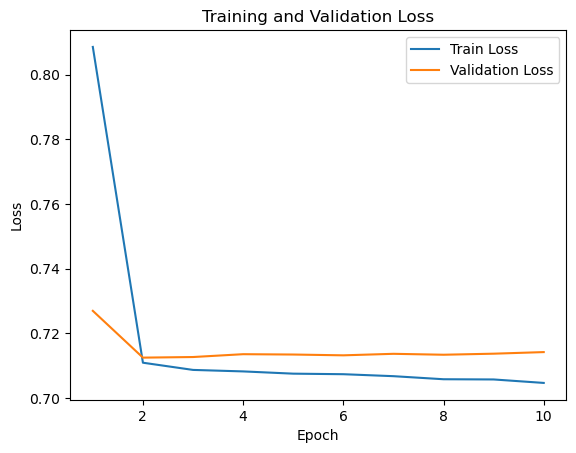

Precision: 0.4469
Recall: 0.8602
Accuracy: 0.4400
ROC-AUC: 0.5107


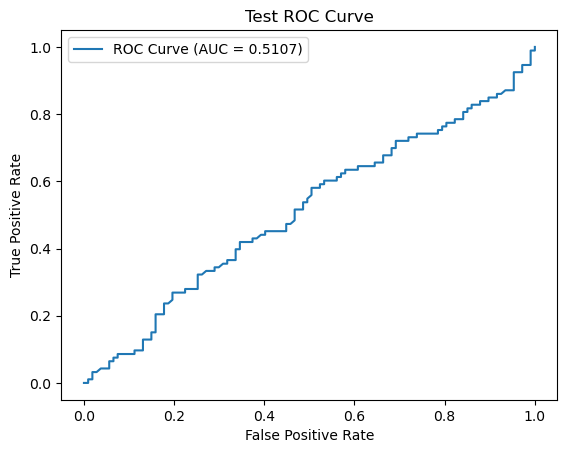

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, Dataset
import numpy as np
from sklearn.metrics import roc_auc_score, roc_curve, precision_score, recall_score, accuracy_score
import matplotlib.pyplot as plt
from torch_geometric.nn import GATConv
from torch_geometric.utils import dense_to_sparse

# Custom dataset for multiple graph pairs
class GraphPairDataset(Dataset):
    def __init__(self, graph_pairs):
        """
        graph_pairs: List of tuples, where each tuple contains:
            - adj1: Adjacency matrix of Graph 1 (n x n)
            - features1: Node features of Graph 1 (n x feature_dim)
            - adj2: Adjacency matrix of Graph 2 (m x m)
            - features2: Node features of Graph 2 (m x feature_dim)
            - interconnections: Ground-truth interconnection matrix (n x m)
        """
        self.graph_pairs = graph_pairs

    def __len__(self):
        return len(self.graph_pairs)

    def __getitem__(self, idx):
        adj1, features1, adj2, features2, interconnections = self.graph_pairs[idx]
        return (
            torch.tensor(features1, dtype=torch.float32),
            torch.tensor(adj1, dtype=torch.float32),
            torch.tensor(features2, dtype=torch.float32),
            torch.tensor(adj2, dtype=torch.float32),
            torch.tensor(interconnections, dtype=torch.float32),
        )

# GAT-based Siamese Network
class GATSiameseNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, heads=1):
        super(GATSiameseNetwork, self).__init__()
        self.gat1 = GATConv(input_dim, hidden_dim, heads=heads, concat=True)
        self.gat2 = GATConv(hidden_dim * heads, output_dim, heads=1, concat=False)
        self.activation = nn.ReLU()
    
    def forward(self, x1, adj1, x2, adj2):
        batch_size = adj1.size(0)  # Number of graphs in the batch
    
        # Prepare edge indices for Graph 1 and Graph 2
        edge_indices1, edge_indices2 = [], []
        for i in range(batch_size):
            adj1[i] = self.normalize_adjacency(adj1[i])
            adj2[i] = self.normalize_adjacency(adj2[i])
            edge_index1, _ = dense_to_sparse(adj1[i])
            edge_index2, _ = dense_to_sparse(adj2[i])
            edge_indices1.append(edge_index1)
            edge_indices2.append(edge_index2)
    
        # Process Graph 1
        outputs1 = []
        for i in range(batch_size):
            x1_i = x1[i]
            edge_index1 = edge_indices1[i]
            x1_out = self.activation(self.gat1(x1_i, edge_index1))
            x1_out = self.gat2(x1_out, edge_index1)
            outputs1.append(x1_out)
    
        # Process Graph 2
        outputs2 = []
        for i in range(batch_size):
            x2_i = x2[i]
            edge_index2 = edge_indices2[i]
            x2_out = self.activation(self.gat1(x2_i, edge_index2))
            x2_out = self.gat2(x2_out, edge_index2)
            outputs2.append(x2_out)
    
        # Compute similarity matrices for each graph pair
        similarities = []
        for x1_out, x2_out in zip(outputs1, outputs2):
            similarity = torch.matmul(x1_out, x2_out.T)  # n x m similarity matrix
            similarities.append(similarity)
    
        # Return batched similarity matrices
        return torch.stack(similarities, dim=0)

    @staticmethod
    def normalize_adjacency(adj):
        """Normalize adjacency matrix using D^(-1/2)AD^(-1/2)."""
        rowsum = adj.sum(dim=1)
        d_inv_sqrt = torch.pow(rowsum, -0.5)
        d_inv_sqrt[torch.isinf(d_inv_sqrt)] = 0
        d_mat_inv_sqrt = torch.diag_embed(d_inv_sqrt)  # Use diag_embed for batch matrices
        return torch.matmul(torch.matmul(d_mat_inv_sqrt, adj), d_mat_inv_sqrt)

# Gradient Clipping Hyperparameter
grad_clip_value = 1.0

# Hyperparameters
input_dim = 16
hidden_dim = 32
output_dim = 16
batch_size = 4
learning_rate = 0.001
num_epochs = 10
val_size = 0.2
test_size = 0.1  # 10% of data for testing

# Example graph pairs
n = 5  # Number of nodes in Graph 1
m = 4  # Number of nodes in Graph 2

# Generate multiple graph pairs
graph_pairs = []
for _ in range(100):  # Generate 100 graph pairs
    adj1 = np.random.rand(n, n)
    adj1 = (adj1 > 0.5).astype(float)  # Binarize to create a valid adjacency matrix
    np.fill_diagonal(adj1, 0)  # Remove self-loops

    adj2 = np.random.rand(m, m)
    adj2 = (adj2 > 0.5).astype(float)  # Binarize to create a valid adjacency matrix
    np.fill_diagonal(adj2, 0)  # Remove self-loops

    features1 = np.random.rand(n, input_dim)
    features2 = np.random.rand(m, input_dim)

    interconnections = np.random.rand(n, m)
    interconnections = (interconnections > 0.5).astype(float)  # Binarize ground-truth

    graph_pairs.append((adj1, features1, adj2, features2, interconnections))

# Split dataset into train, validation, and test sets
dataset = GraphPairDataset(graph_pairs)
train_size = int((1 - val_size - test_size) * len(dataset))
val_size = int(val_size * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Initialize model, loss, and optimizer
model = GATSiameseNetwork(input_dim, hidden_dim, output_dim)
# criterion = nn.BCEWithLogitsLoss()
# optimizer = optim.Adam(model.parameters(), lr=learning_rate)


all_interconnections = [pair[4] for pair in train_dataset]
all_interconnections_flat = np.concatenate([ic.flatten() for ic in all_interconnections])
positive_weight = np.sum(all_interconnections_flat) / np.sum(1 - all_interconnections_flat)
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([positive_weight]))
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


# Training loop
train_losses, val_losses = [], []
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for features1, adj1, features2, adj2, interconnections in train_dataloader:
        optimizer.zero_grad()
        predicted = model(features1, adj1, features2, adj2)
        loss = criterion(predicted, interconnections)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip_value)
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / len(train_dataloader)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for features1, adj1, features2, adj2, interconnections in val_dataloader:
            predicted = model(features1, adj1, features2, adj2)
            loss = criterion(predicted, interconnections)
            val_loss += loss.item()
    val_loss /= len(val_dataloader)
    val_losses.append(val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

# Plot training and validation loss
plt.figure()
plt.plot(range(1, num_epochs + 1), train_losses, label="Train Loss")
plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

# Test evaluation
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for features1, adj1, features2, adj2, interconnections in test_dataloader:
        predicted = model(features1, adj1, features2, adj2)
        all_preds.append(predicted.numpy())
        all_labels.append(interconnections.numpy())

all_preds = np.concatenate(all_preds, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

all_preds_probs = 1 / (1 + np.exp(-all_preds))
threshold = 0.5
binary_preds = (all_preds_probs > threshold).astype(float)

# Compute test metrics
precision = precision_score(all_labels.flatten(), binary_preds.flatten())
recall = recall_score(all_labels.flatten(), binary_preds.flatten())
accuracy = accuracy_score(all_labels.flatten(), binary_preds.flatten())
roc_auc = roc_auc_score(all_labels.flatten(), all_preds_probs.flatten())

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")

# Plot ROC curve for test set
fpr, tpr, _ = roc_curve(all_labels.flatten(), all_preds_probs.flatten())
plt.figure()
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Test ROC Curve")
plt.legend()
plt.show()

Epoch [1/10], Train Loss: 0.9020, Val Loss: 0.7346
Epoch [2/10], Train Loss: 0.7090, Val Loss: 0.7025
Epoch [3/10], Train Loss: 0.7021, Val Loss: 0.7017
Epoch [4/10], Train Loss: 0.7008, Val Loss: 0.7003
Epoch [5/10], Train Loss: 0.6997, Val Loss: 0.7007
Epoch [6/10], Train Loss: 0.7003, Val Loss: 0.7014
Epoch [7/10], Train Loss: 0.7003, Val Loss: 0.7002
Epoch [8/10], Train Loss: 0.6992, Val Loss: 0.7006
Epoch [9/10], Train Loss: 0.6994, Val Loss: 0.7015
Epoch [10/10], Train Loss: 0.6991, Val Loss: 0.6997


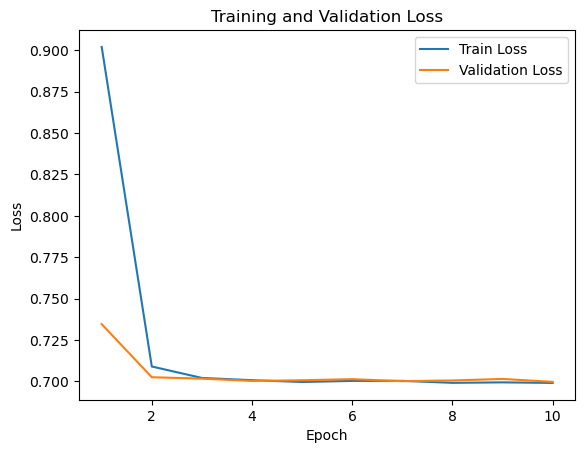

Precision: 0.5281
Recall: 0.9126
Accuracy: 0.5350
ROC-AUC: 0.5762


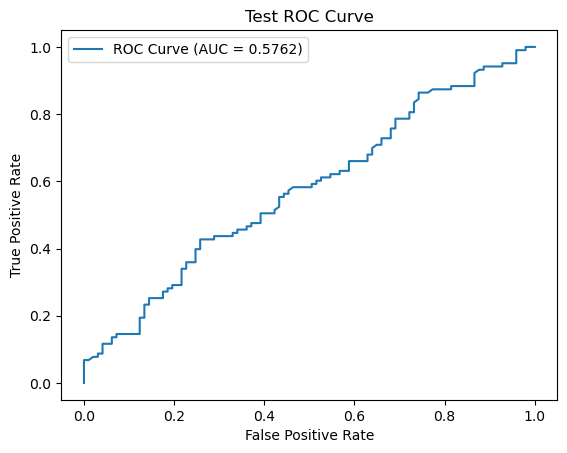

In [68]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, Dataset
import numpy as np
from sklearn.metrics import roc_auc_score, roc_curve, precision_score, recall_score, accuracy_score
import matplotlib.pyplot as plt
from torch_geometric.nn import GATConv
from torch_geometric.utils import dense_to_sparse
rng = np.random.RandomState(42)
seed = 42  # You can choose any integer for reproducibility
torch.manual_seed(seed)

# Custom dataset for multiple graph pairs
class GraphPairDataset(Dataset):
    def __init__(self, graph_pairs):
        self.graph_pairs = graph_pairs

    def __len__(self):
        return len(self.graph_pairs)

    def __getitem__(self, idx):
        adj1, features1, adj2, features2, interconnections = self.graph_pairs[idx]
        return (
            torch.tensor(features1, dtype=torch.float32),
            torch.tensor(adj1, dtype=torch.float32),
            torch.tensor(features2, dtype=torch.float32),
            torch.tensor(adj2, dtype=torch.float32),
            torch.tensor(interconnections, dtype=torch.float32),
        )

# GAT-based Siamese Network
class GATSiameseNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, heads=1):
        super(GATSiameseNetwork, self).__init__()
        self.gat1 = GATConv(input_dim, hidden_dim, heads=heads, concat=True)
        self.gat2 = GATConv(hidden_dim * heads, output_dim, heads=1, concat=False)
        self.activation = nn.ReLU()

        # Learnable regularization weights
        self.sparsity_weight = nn.Parameter(torch.tensor(0.01, requires_grad=True))
        self.clustering_weight = nn.Parameter(torch.tensor(0.001, requires_grad=True))
        self.jaccard_weight = nn.Parameter(torch.tensor(0.0001, requires_grad=True))
        # self.spectral_weight = nn.Parameter(torch.tensor(0.01, requires_grad=True))
    
    def forward(self, x1, adj1, x2, adj2):
        batch_size = adj1.size(0)  # Number of graphs in the batch
    
        # Prepare edge indices for Graph 1 and Graph 2
        edge_indices1, edge_indices2 = [], []
        for i in range(batch_size):
            adj1[i] = self.normalize_adjacency(adj1[i])
            adj2[i] = self.normalize_adjacency(adj2[i])
            edge_index1, _ = dense_to_sparse(adj1[i])
            edge_index2, _ = dense_to_sparse(adj2[i])
            edge_indices1.append(edge_index1)
            edge_indices2.append(edge_index2)
    
        # Process Graph 1
        outputs1 = []
        for i in range(batch_size):
            x1_i = x1[i]
            edge_index1 = edge_indices1[i]
            x1_out = self.activation(self.gat1(x1_i, edge_index1))
            x1_out = self.gat2(x1_out, edge_index1)
            outputs1.append(x1_out)
    
        # Process Graph 2
        outputs2 = []
        for i in range(batch_size):
            x2_i = x2[i]
            edge_index2 = edge_indices2[i]
            x2_out = self.activation(self.gat1(x2_i, edge_index2))
            x2_out = self.gat2(x2_out, edge_index2)
            outputs2.append(x2_out)
    
        # Compute similarity matrices for each graph pair
        similarities = []
        for x1_out, x2_out in zip(outputs1, outputs2):
            similarity = torch.matmul(x1_out, x2_out.T)  # n x m similarity matrix
            similarities.append(similarity)
    
        # Return batched similarity matrices
        return torch.stack(similarities, dim=0)

    @staticmethod
    def normalize_adjacency(adj):
        """Normalize adjacency matrix using D^(-1/2)AD^(-1/2)."""
        rowsum = adj.sum(dim=1)
        d_inv_sqrt = torch.pow(rowsum, -0.5)
        d_inv_sqrt[torch.isinf(d_inv_sqrt)] = 0
        d_mat_inv_sqrt = torch.diag_embed(d_inv_sqrt)  # Use diag_embed for batch matrices
        return torch.matmul(torch.matmul(d_mat_inv_sqrt, adj), d_mat_inv_sqrt)

def sparsity_regularization(predicted_inter, adj1, adj2, true_inter):
    """
    Penalizes deviations in sparsity between the original full graph and the new full graph.
    """
    batch_size = adj1.size(0)
    sparsity_loss = 0.0

    for i in range(batch_size):
        # Original full graph (with ground-truth interconnections)
        A1 = adj1[i]  # Adjacency matrix of Graph 1 (n x n)
        A2 = adj2[i]  # Adjacency matrix of Graph 2 (m x m)
        true_S = true_inter[i]  # Ground-truth interconnections (n x m)
        original_full_adj = torch.block_diag(A1, A2)  # Block diagonal matrix for A1 and A2
        original_full_adj[:A1.size(0), A1.size(0):] = true_S  # Add ground-truth inter-graph edges
        original_full_adj[A1.size(0):, :A1.size(0)] = true_S.T  # Add symmetric inter-graph edges

        # New full graph (with predicted interconnections)
        pred_S = predicted_inter[i]  # Predicted interconnections (n x m)
        new_full_adj = torch.block_diag(A1, A2)  # Block diagonal matrix for A1 and A2
        new_full_adj[:A1.size(0), A1.size(0):] = pred_S  # Add predicted inter-graph edges
        new_full_adj[A1.size(0):, :A1.size(0)] = pred_S.T  # Add symmetric inter-graph edges

        # Compute sparsity of both graphs
        original_sparsity = torch.mean((original_full_adj != 0).float())
        new_sparsity = torch.mean((new_full_adj != 0).float())

        # Penalize deviation in sparsity
        sparsity_loss += torch.abs(original_sparsity - new_sparsity)

    # Average over the batch
    return sparsity_loss / batch_size

def compute_clustering_coefficient(adj):
    """
    Computes the global clustering coefficient for a given adjacency matrix.
    """
    # Ensure the adjacency matrix is symmetric (undirected graph)
    adj = (adj + adj.T) / 2
    adj = (adj > 0).float()  # Binarize

    # Compute the number of triangles and triplets
    A_cubed = torch.matrix_power(adj, 3)
    num_triangles = torch.trace(A_cubed) / 6  # Each triangle is counted 6 times
    num_triplets = torch.sum(torch.pow(adj.sum(dim=1), 2)) - torch.sum(torch.pow(adj, 2).sum(dim=1))

    # Avoid division by zero
    if num_triplets == 0:
        return torch.tensor(0.0)

    # Global clustering coefficient
    clustering_coeff = 3 * num_triangles / num_triplets
    return clustering_coeff

def clustering_coefficient_regularization(predicted_inter, adj1, adj2, true_inter):
    """
    Penalizes deviations in clustering coefficient between the original full graph and the new full graph.
    """
    batch_size = adj1.size(0)
    clustering_loss = 0.0

    for i in range(batch_size):
        # Original full graph (with ground-truth interconnections)
        A1 = adj1[i]  # Adjacency matrix of Graph 1 (n x n)
        A2 = adj2[i]  # Adjacency matrix of Graph 2 (m x m)
        true_S = true_inter[i]  # Ground-truth interconnections (n x m)
        original_full_adj = torch.block_diag(A1, A2)  # Block diagonal matrix for A1 and A2
        original_full_adj[:A1.size(0), A1.size(0):] = true_S  # Add ground-truth inter-graph edges
        original_full_adj[A1.size(0):, :A1.size(0)] = true_S.T  # Add symmetric inter-graph edges

        # New full graph (with predicted interconnections)
        pred_S = predicted_inter[i]  # Predicted interconnections (n x m)
        new_full_adj = torch.block_diag(A1, A2)  # Block diagonal matrix for A1 and A2
        new_full_adj[:A1.size(0), A1.size(0):] = pred_S  # Add predicted inter-graph edges
        new_full_adj[A1.size(0):, :A1.size(0)] = pred_S.T  # Add symmetric inter-graph edges

        # Compute clustering coefficient for both graphs
        original_clustering = compute_clustering_coefficient(original_full_adj)
        new_clustering = compute_clustering_coefficient(new_full_adj)

        # Penalize deviation in clustering coefficient
        clustering_loss += torch.abs(original_clustering - new_clustering)

    # Average over the batch
    return clustering_loss / batch_size

def compute_k_hop_neighborhood(adj, k):
    """
    Computes the k-hop neighborhood for each node in the graph.
    """
    adj_power = torch.eye(adj.size(0), device=adj.device)  # Identity matrix
    k_hop_neighborhood = torch.zeros_like(adj)
    for _ in range(k):
        adj_power = torch.matmul(adj_power, adj)
        k_hop_neighborhood += adj_power
    k_hop_neighborhood = (k_hop_neighborhood > 0).float()  # Binarize
    return k_hop_neighborhood

def k_hop_jaccard_regularization(predicted_inter, adj1, adj2, true_inter, k):
    """
    Penalizes deviations in k-hop Jaccard overlap between the original full graph and the new full graph.
    """
    batch_size = adj1.size(0)
    jaccard_loss = 0.0

    for i in range(batch_size):
        # Original full graph (with ground-truth interconnections)
        A1 = adj1[i]  # Adjacency matrix of Graph 1 (n x n)
        A2 = adj2[i]  # Adjacency matrix of Graph 2 (m x m)
        true_S = true_inter[i]  # Ground-truth interconnections (n x m)
        original_full_adj = torch.block_diag(A1, A2)  # Block diagonal matrix for A1 and A2
        original_full_adj[:A1.size(0), A1.size(0):] = true_S  # Add ground-truth inter-graph edges
        original_full_adj[A1.size(0):, :A1.size(0)] = true_S.T  # Add symmetric inter-graph edges

        # New full graph (with predicted interconnections)
        pred_S = predicted_inter[i]  # Predicted interconnections (n x m)
        new_full_adj = torch.block_diag(A1, A2)  # Block diagonal matrix for A1 and A2
        new_full_adj[:A1.size(0), A1.size(0):] = pred_S  # Add predicted inter-graph edges
        new_full_adj[A1.size(0):, :A1.size(0)] = pred_S.T  # Add symmetric inter-graph edges

        # Compute k-hop Jaccard overlap for both graphs
        original_jaccard = compute_k_hop_neighborhood(original_full_adj, k)
        new_jaccard = compute_k_hop_neighborhood(new_full_adj, k)

        # Penalize deviation in k-hop Jaccard overlap
        jaccard_loss += torch.norm(original_jaccard - new_jaccard, p=1)

    # Average over the batch
    return jaccard_loss / batch_size

def compute_spectral_embedding(adj, num_eigenvectors=16, epsilon=1e-6):
    """
    Computes the spectral embedding of a graph using the eigenvectors of its graph Laplacian.
    """
    # Ensure the adjacency matrix is symmetric and has no self-loops
    adj = (adj + adj.T) / 2  # Enforce symmetry
    adj.diagonal().fill_(0)  # Remove self-loops

    # Normalize the adjacency matrix
    def normalize_adjacency(adj):
        rowsum = adj.sum(dim=1)
        d_inv_sqrt = torch.pow(rowsum, -0.5)
        d_inv_sqrt[torch.isinf(d_inv_sqrt)] = 0
        d_mat_inv_sqrt = torch.diag_embed(d_inv_sqrt)
        return d_mat_inv_sqrt @ adj @ d_mat_inv_sqrt

    adj = normalize_adjacency(adj)

    # Compute the graph Laplacian
    degree = torch.diag(torch.sum(adj, dim=1))
    laplacian = degree - adj

    # Add a small regularization term
    laplacian = laplacian + epsilon * torch.eye(laplacian.size(0), device=laplacian.device)

    # Enforce symmetry
    laplacian = (laplacian + laplacian.T) / 2

    # Compute eigenvalues and eigenvectors
    try:
        eigenvalues, eigenvectors = torch.linalg.eigh(laplacian)
    except RuntimeError:
        print("Switching to scipy.linalg.eigh due to instability.")
        from scipy.linalg import eigh
        laplacian_np = laplacian.detach().cpu().numpy()
        eigenvalues, eigenvectors = eigh(laplacian_np)
        eigenvalues = torch.tensor(eigenvalues, device=laplacian.device)
        eigenvectors = torch.tensor(eigenvectors, device=laplacian.device)

    # Use the smallest non-zero eigenvectors
    spectral_embedding = eigenvectors[:, 1:num_eigenvectors+1]
    return spectral_embedding

def spectral_embedding_regularization(predicted_inter, adj1, adj2, true_inter, num_eigenvectors=16):
    """
    Penalizes deviations in spectral embeddings between the original full graph and the new full graph.
    """
    batch_size = adj1.size(0)
    spectral_loss = 0.0

    for i in range(batch_size):
        # Original full graph (with ground-truth interconnections)
        A1 = adj1[i]  # Adjacency matrix of Graph 1 (n x n)
        A2 = adj2[i]  # Adjacency matrix of Graph 2 (m x m)
        true_S = true_inter[i]  # Ground-truth interconnections (n x m)
        original_full_adj = torch.block_diag(A1, A2)  # Block diagonal matrix for A1 and A2
        original_full_adj[:A1.size(0), A1.size(0):] = true_S  # Add ground-truth inter-graph edges
        original_full_adj[A1.size(0):, :A1.size(0)] = true_S.T  # Add symmetric inter-graph edges

        # New full graph (with predicted interconnections)
        pred_S = predicted_inter[i]  # Predicted interconnections (n x m)
        new_full_adj = torch.block_diag(A1, A2)  # Block diagonal matrix for A1 and A2
        new_full_adj[:A1.size(0), A1.size(0):] = pred_S  # Add predicted inter-graph edges
        new_full_adj[A1.size(0):, :A1.size(0)] = pred_S.T  # Add symmetric inter-graph edges

        # Compute spectral embeddings for both graphs
        original_spectral = compute_spectral_embedding(original_full_adj, num_eigenvectors)
        new_spectral = compute_spectral_embedding(new_full_adj, num_eigenvectors)

        # Penalize deviation in spectral embeddings
        spectral_loss += torch.norm(original_spectral - new_spectral, p=1)

    # Average over the batch
    return spectral_loss / batch_size

# Gradient Clipping Hyperparameter
grad_clip_value = 1.0

# Hyperparameters
input_dim = 16
hidden_dim = 32
output_dim = 16
batch_size = 4
learning_rate = 0.001
num_epochs = 10
val_size = 0.2
test_size = 0.1  # 10% of data for testing
lambda_sparsity = 0.0001  # Regularization strength for sparsity
lambda_clustering = 0.0001  # Regularization strength for clustering coefficient
lambda_jaccard = 0.0001  # Regularization strength for k-hop Jaccard overlap
lambda_spectral = 0.0001  # Regularization strength for spectral embedding
k = 2  # Number of hops for k-hop Jaccard
num_eigenvectors = 16  # Number of eigenvectors for spectral embedding

# Example graph pairs
n = 5  # Number of nodes in Graph 1
m = 4  # Number of nodes in Graph 2

# Generate multiple graph pairs
graph_pairs = []
for _ in range(100):  # Generate 100 graph pairs
    adj1 = rng.rand(n, n)
    adj1 = (adj1 > 0.5).astype(float)  # Binarize to create a valid adjacency matrix
    np.fill_diagonal(adj1, 0)  # Remove self-loops

    adj2 = rng.rand(m, m)
    adj2 = (adj2 > 0.5).astype(float)  # Binarize to create a valid adjacency matrix
    np.fill_diagonal(adj2, 0)  # Remove self-loops

    features1 = rng.rand(n, input_dim)
    features2 = rng.rand(m, input_dim)

    interconnections = rng.rand(n, m)
    interconnections = (interconnections > 0.5).astype(float)  # Binarize ground-truth

    graph_pairs.append((adj1, features1, adj2, features2, interconnections))

# Split dataset into train, validation, and test sets
dataset = GraphPairDataset(graph_pairs)
train_size = int((1 - val_size - test_size) * len(dataset))
val_size = int(val_size * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Initialize model, loss, and optimizer
model = GATSiameseNetwork(input_dim, hidden_dim, output_dim)
all_interconnections = [pair[4] for pair in train_dataset]
all_interconnections_flat = np.concatenate([ic.flatten() for ic in all_interconnections])
positive_weight = np.sum(all_interconnections_flat) / np.sum(1 - all_interconnections_flat)
# criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([positive_weight]))
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

def compute_total_loss_with_normalized_weights(model, predicted_inter, adj1, adj2, true_inter, k):
    """
    Computes the total loss with normalized weights for regularization terms.
    """
    # Normalize weights
    weights = torch.softmax(
        torch.stack([model.sparsity_weight, model.clustering_weight, model.jaccard_weight]), dim=0
    )

    # Task-specific loss
    task_loss = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([positive_weight]))(predicted_inter, true_inter)

    # Regularization terms
    sparsity_loss = sparsity_regularization(predicted_inter, adj1, adj2, true_inter)
    clustering_loss = clustering_coefficient_regularization(predicted_inter, adj1, adj2, true_inter)
    jaccard_loss = k_hop_jaccard_regularization(predicted_inter, adj1, adj2, true_inter, k)
    # spectral_loss = spectral_embedding_regularization(predicted_inter, adj1, adj2, true_inter, num_eigenvectors)

    # Combine all losses with normalized weights
    total_loss = (
        task_loss +
        weights[0] * model.sparsity_weight.item() * sparsity_loss +
        weights[1] * model.clustering_weight.item() * clustering_loss +
        weights[2] * model.jaccard_weight.item() * jaccard_loss 
        # weights[3] * model.spectral_weight.item() * spectral_loss
    )
    # print(f"Sparsity Weight: {model.sparsity_weight.item()}")
    # print(f"Clustering Weight: {model.clustering_weight.item()}")
    # print(f"Jaccard Weight: {model.jaccard_weight.item()}")
    # print(f"Spectral Weight: {model.spectral_weight.item()}")

    return total_loss

# Training loop
train_losses, val_losses = [], []
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for features1, adj1, features2, adj2, interconnections in train_dataloader:

        optimizer.zero_grad()
        predicted_inter = model(features1, adj1, features2, adj2)

        # # Weighted BCE loss
        # bce_loss = criterion(predicted, interconnections)


        # Total loss
        total_loss = compute_total_loss_with_normalized_weights(model, predicted_inter, adj1, adj2, interconnections, k)

        # Backpropagation
        total_loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip_value)
        optimizer.step()
        running_loss += total_loss.item()

    train_loss = running_loss / len(train_dataloader)
    train_losses.append(train_loss)

    # Validation (no regularization terms)
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for features1, adj1, features2, adj2, interconnections in val_dataloader:
            predicted_inter = model(features1, adj1, features2, adj2)
            # loss = criterion(predicted, interconnections)
            loss = compute_total_loss_with_normalized_weights(model, predicted_inter, adj1, adj2, interconnections, k)
            val_loss += loss.item()
    val_loss /= len(val_dataloader)
    val_losses.append(val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

# Plot training and validation loss
plt.figure()
plt.plot(range(1, num_epochs + 1), train_losses, label="Train Loss")
plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

# Test evaluation
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for features1, adj1, features2, adj2, interconnections in test_dataloader:
        predicted = model(features1, adj1, features2, adj2)
        all_preds.append(predicted.numpy())
        all_labels.append(interconnections.numpy())

all_preds = np.concatenate(all_preds, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

all_preds_probs = 1 / (1 + np.exp(-all_preds))
threshold = 0.5
binary_preds = (all_preds_probs > threshold).astype(float)

# Compute test metrics
precision = precision_score(all_labels.flatten(), binary_preds.flatten())
recall = recall_score(all_labels.flatten(), binary_preds.flatten())
accuracy = accuracy_score(all_labels.flatten(), binary_preds.flatten())
roc_auc = roc_auc_score(all_labels.flatten(), all_preds_probs.flatten())

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")

# Plot ROC curve for test set
fpr, tpr, _ = roc_curve(all_labels.flatten(), all_preds_probs.flatten())
plt.figure()
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Test ROC Curve")
plt.legend()
plt.show()

In [71]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, Dataset
import numpy as np
from sklearn.metrics import roc_auc_score, roc_curve, precision_score, recall_score, accuracy_score
import matplotlib.pyplot as plt
from torch_geometric.nn import GATConv
from torch_geometric.utils import dense_to_sparse
rng = np.random.RandomState(42)
seed = 42  # You can choose any integer for reproducibility
torch.manual_seed(seed)

# Custom dataset for multiple graph pairs
class GraphPairDataset(Dataset):
    def __init__(self, graph_pairs):
        self.graph_pairs = graph_pairs

    def __len__(self):
        return len(self.graph_pairs)

    def __getitem__(self, idx):
        adj1, features1, adj2, features2, interconnections = self.graph_pairs[idx]
        return (
            torch.tensor(features1, dtype=torch.float32),
            torch.tensor(adj1, dtype=torch.float32),
            torch.tensor(features2, dtype=torch.float32),
            torch.tensor(adj2, dtype=torch.float32),
            torch.tensor(interconnections, dtype=torch.float32),
        )

# GAT-based Siamese Network
class GATSiameseNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, heads=1):
        super(GATSiameseNetwork, self).__init__()
        self.gat1 = GATConv(input_dim, hidden_dim, heads=heads, concat=True)
        self.gat2 = GATConv(hidden_dim * heads, output_dim, heads=1, concat=False)
        self.activation = nn.ReLU()

        # Learnable regularization weights
        self.sparsity_weight = nn.Parameter(torch.tensor(0.01, requires_grad=True))
        self.clustering_weight = nn.Parameter(torch.tensor(0.001, requires_grad=True))
        self.jaccard_weight = nn.Parameter(torch.tensor(0.0001, requires_grad=True))
        # self.spectral_weight = nn.Parameter(torch.tensor(0.01, requires_grad=True))
    
    def forward(self, x1, adj1, x2, adj2):
        batch_size = adj1.size(0)  # Number of graphs in the batch
    
        # Prepare edge indices for Graph 1 and Graph 2
        edge_indices1, edge_indices2 = [], []
        for i in range(batch_size):
            adj1[i] = self.normalize_adjacency(adj1[i])
            adj2[i] = self.normalize_adjacency(adj2[i])
            edge_index1, _ = dense_to_sparse(adj1[i])
            edge_index2, _ = dense_to_sparse(adj2[i])
            edge_indices1.append(edge_index1)
            edge_indices2.append(edge_index2)
    
        # Process Graph 1
        outputs1 = []
        for i in range(batch_size):
            x1_i = x1[i]
            edge_index1 = edge_indices1[i]
            x1_out = self.activation(self.gat1(x1_i, edge_index1))
            x1_out = self.gat2(x1_out, edge_index1)
            outputs1.append(x1_out)
    
        # Process Graph 2
        outputs2 = []
        for i in range(batch_size):
            x2_i = x2[i]
            edge_index2 = edge_indices2[i]
            x2_out = self.activation(self.gat1(x2_i, edge_index2))
            x2_out = self.gat2(x2_out, edge_index2)
            outputs2.append(x2_out)
    
        # Compute similarity matrices for each graph pair
        similarities = []
        for x1_out, x2_out in zip(outputs1, outputs2):
            similarity = torch.matmul(x1_out, x2_out.T)  # n x m similarity matrix
            similarities.append(similarity)
    
        # Return batched similarity matrices
        return torch.stack(similarities, dim=0)

    @staticmethod
    def normalize_adjacency(adj):
        """Normalize adjacency matrix using D^(-1/2)AD^(-1/2)."""
        rowsum = adj.sum(dim=1)
        d_inv_sqrt = torch.pow(rowsum, -0.5)
        d_inv_sqrt[torch.isinf(d_inv_sqrt)] = 0
        d_mat_inv_sqrt = torch.diag_embed(d_inv_sqrt)  # Use diag_embed for batch matrices
        return torch.matmul(torch.matmul(d_mat_inv_sqrt, adj), d_mat_inv_sqrt)

def sparsity_regularization(predicted_inter, adj1, adj2, true_inter):
    """
    Penalizes deviations in sparsity between the original full graph and the new full graph.
    """
    batch_size = adj1.size(0)
    sparsity_loss = 0.0

    for i in range(batch_size):
        # Original full graph (with ground-truth interconnections)
        A1 = adj1[i]  # Adjacency matrix of Graph 1 (n x n)
        A2 = adj2[i]  # Adjacency matrix of Graph 2 (m x m)
        true_S = true_inter[i]  # Ground-truth interconnections (n x m)
        original_full_adj = torch.block_diag(A1, A2)  # Block diagonal matrix for A1 and A2
        original_full_adj[:A1.size(0), A1.size(0):] = true_S  # Add ground-truth inter-graph edges
        original_full_adj[A1.size(0):, :A1.size(0)] = true_S.T  # Add symmetric inter-graph edges

        # New full graph (with predicted interconnections)
        pred_S = predicted_inter[i]  # Predicted interconnections (n x m)
        new_full_adj = torch.block_diag(A1, A2)  # Block diagonal matrix for A1 and A2
        new_full_adj[:A1.size(0), A1.size(0):] = pred_S  # Add predicted inter-graph edges
        new_full_adj[A1.size(0):, :A1.size(0)] = pred_S.T  # Add symmetric inter-graph edges

        # Compute sparsity of both graphs
        original_sparsity = torch.mean((original_full_adj != 0).float())
        new_sparsity = torch.mean((new_full_adj != 0).float())

        # Penalize deviation in sparsity
        sparsity_loss += torch.abs(original_sparsity - new_sparsity)

    # Average over the batch
    return sparsity_loss / batch_size

def compute_clustering_coefficient(adj):
    """
    Computes the global clustering coefficient for a given adjacency matrix.
    """
    # Ensure the adjacency matrix is symmetric (undirected graph)
    adj = (adj + adj.T) / 2
    adj = (adj > 0).float()  # Binarize

    # Compute the number of triangles and triplets
    A_cubed = torch.matrix_power(adj, 3)
    num_triangles = torch.trace(A_cubed) / 6  # Each triangle is counted 6 times
    num_triplets = torch.sum(torch.pow(adj.sum(dim=1), 2)) - torch.sum(torch.pow(adj, 2).sum(dim=1))

    # Avoid division by zero
    if num_triplets == 0:
        return torch.tensor(0.0)

    # Global clustering coefficient
    clustering_coeff = 3 * num_triangles / num_triplets
    return clustering_coeff

def clustering_coefficient_regularization(predicted_inter, adj1, adj2, true_inter):
    """
    Penalizes deviations in clustering coefficient between the original full graph and the new full graph.
    """
    batch_size = adj1.size(0)
    clustering_loss = 0.0

    for i in range(batch_size):
        # Original full graph (with ground-truth interconnections)
        A1 = adj1[i]  # Adjacency matrix of Graph 1 (n x n)
        A2 = adj2[i]  # Adjacency matrix of Graph 2 (m x m)
        true_S = true_inter[i]  # Ground-truth interconnections (n x m)
        original_full_adj = torch.block_diag(A1, A2)  # Block diagonal matrix for A1 and A2
        original_full_adj[:A1.size(0), A1.size(0):] = true_S  # Add ground-truth inter-graph edges
        original_full_adj[A1.size(0):, :A1.size(0)] = true_S.T  # Add symmetric inter-graph edges

        # New full graph (with predicted interconnections)
        pred_S = predicted_inter[i]  # Predicted interconnections (n x m)
        new_full_adj = torch.block_diag(A1, A2)  # Block diagonal matrix for A1 and A2
        new_full_adj[:A1.size(0), A1.size(0):] = pred_S  # Add predicted inter-graph edges
        new_full_adj[A1.size(0):, :A1.size(0)] = pred_S.T  # Add symmetric inter-graph edges

        # Compute clustering coefficient for both graphs
        original_clustering = compute_clustering_coefficient(original_full_adj)
        new_clustering = compute_clustering_coefficient(new_full_adj)

        # Penalize deviation in clustering coefficient
        clustering_loss += torch.abs(original_clustering - new_clustering)

    # Average over the batch
    return clustering_loss / batch_size

def compute_k_hop_neighborhood(adj, k):
    """
    Computes the k-hop neighborhood for each node in the graph.
    """
    adj_power = torch.eye(adj.size(0), device=adj.device)  # Identity matrix
    k_hop_neighborhood = torch.zeros_like(adj)
    for _ in range(k):
        adj_power = torch.matmul(adj_power, adj)
        k_hop_neighborhood += adj_power
    k_hop_neighborhood = (k_hop_neighborhood > 0).float()  # Binarize
    return k_hop_neighborhood

def k_hop_jaccard_regularization(predicted_inter, adj1, adj2, true_inter, k):
    """
    Penalizes deviations in k-hop Jaccard overlap between the original full graph and the new full graph.
    """
    batch_size = adj1.size(0)
    jaccard_loss = 0.0

    for i in range(batch_size):
        # Original full graph (with ground-truth interconnections)
        A1 = adj1[i]  # Adjacency matrix of Graph 1 (n x n)
        A2 = adj2[i]  # Adjacency matrix of Graph 2 (m x m)
        true_S = true_inter[i]  # Ground-truth interconnections (n x m)
        original_full_adj = torch.block_diag(A1, A2)  # Block diagonal matrix for A1 and A2
        original_full_adj[:A1.size(0), A1.size(0):] = true_S  # Add ground-truth inter-graph edges
        original_full_adj[A1.size(0):, :A1.size(0)] = true_S.T  # Add symmetric inter-graph edges

        # New full graph (with predicted interconnections)
        pred_S = predicted_inter[i]  # Predicted interconnections (n x m)
        new_full_adj = torch.block_diag(A1, A2)  # Block diagonal matrix for A1 and A2
        new_full_adj[:A1.size(0), A1.size(0):] = pred_S  # Add predicted inter-graph edges
        new_full_adj[A1.size(0):, :A1.size(0)] = pred_S.T  # Add symmetric inter-graph edges

        # Compute k-hop Jaccard overlap for both graphs
        original_jaccard = compute_k_hop_neighborhood(original_full_adj, k)
        new_jaccard = compute_k_hop_neighborhood(new_full_adj, k)

        # Penalize deviation in k-hop Jaccard overlap
        jaccard_loss += torch.norm(original_jaccard - new_jaccard, p=1)

    # Average over the batch
    return jaccard_loss / batch_size

def compute_spectral_embedding(adj, num_eigenvectors=16, epsilon=1e-6):
    """
    Computes the spectral embedding of a graph using the eigenvectors of its graph Laplacian.
    """
    # Ensure the adjacency matrix is symmetric and has no self-loops
    adj = (adj + adj.T) / 2  # Enforce symmetry
    adj.diagonal().fill_(0)  # Remove self-loops

    # Normalize the adjacency matrix
    def normalize_adjacency(adj):
        rowsum = adj.sum(dim=1)
        d_inv_sqrt = torch.pow(rowsum, -0.5)
        d_inv_sqrt[torch.isinf(d_inv_sqrt)] = 0
        d_mat_inv_sqrt = torch.diag_embed(d_inv_sqrt)
        return d_mat_inv_sqrt @ adj @ d_mat_inv_sqrt

    adj = normalize_adjacency(adj)

    # Compute the graph Laplacian
    degree = torch.diag(torch.sum(adj, dim=1))
    laplacian = degree - adj

    # Add a small regularization term
    laplacian = laplacian + epsilon * torch.eye(laplacian.size(0), device=laplacian.device)

    # Enforce symmetry
    laplacian = (laplacian + laplacian.T) / 2

    # Compute eigenvalues and eigenvectors
    try:
        eigenvalues, eigenvectors = torch.linalg.eigh(laplacian)
    except RuntimeError:
        print("Switching to scipy.linalg.eigh due to instability.")
        from scipy.linalg import eigh
        laplacian_np = laplacian.detach().cpu().numpy()
        eigenvalues, eigenvectors = eigh(laplacian_np)
        eigenvalues = torch.tensor(eigenvalues, device=laplacian.device)
        eigenvectors = torch.tensor(eigenvectors, device=laplacian.device)

    # Use the smallest non-zero eigenvectors
    spectral_embedding = eigenvectors[:, 1:num_eigenvectors+1]
    return spectral_embedding

def spectral_embedding_regularization(predicted_inter, adj1, adj2, true_inter, num_eigenvectors=16):
    """
    Penalizes deviations in spectral embeddings between the original full graph and the new full graph.
    """
    batch_size = adj1.size(0)
    spectral_loss = 0.0

    for i in range(batch_size):
        # Original full graph (with ground-truth interconnections)
        A1 = adj1[i]  # Adjacency matrix of Graph 1 (n x n)
        A2 = adj2[i]  # Adjacency matrix of Graph 2 (m x m)
        true_S = true_inter[i]  # Ground-truth interconnections (n x m)
        original_full_adj = torch.block_diag(A1, A2)  # Block diagonal matrix for A1 and A2
        original_full_adj[:A1.size(0), A1.size(0):] = true_S  # Add ground-truth inter-graph edges
        original_full_adj[A1.size(0):, :A1.size(0)] = true_S.T  # Add symmetric inter-graph edges

        # New full graph (with predicted interconnections)
        pred_S = predicted_inter[i]  # Predicted interconnections (n x m)
        new_full_adj = torch.block_diag(A1, A2)  # Block diagonal matrix for A1 and A2
        new_full_adj[:A1.size(0), A1.size(0):] = pred_S  # Add predicted inter-graph edges
        new_full_adj[A1.size(0):, :A1.size(0)] = pred_S.T  # Add symmetric inter-graph edges

        # Compute spectral embeddings for both graphs
        original_spectral = compute_spectral_embedding(original_full_adj, num_eigenvectors)
        new_spectral = compute_spectral_embedding(new_full_adj, num_eigenvectors)

        # Penalize deviation in spectral embeddings
        spectral_loss += torch.norm(original_spectral - new_spectral, p=1)

    # Average over the batch
    return spectral_loss / batch_size

class NodeFeatureProjection(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(NodeFeatureProjection, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        return self.linear(x)

def compute_jaccard_similarity(k_hop_neighborhood):
    n = k_hop_neighborhood.size(0)
    jaccard_matrix = torch.zeros((n, n), device=k_hop_neighborhood.device)

    for i in range(n):
        for j in range(n):
            # Neighborhoods of nodes i and j
            A = k_hop_neighborhood[i]
            B = k_hop_neighborhood[j]

            # Compute intersection and union
            intersection = (A * B).sum()
            union = (A + B).clamp(max=1).sum()

            # Avoid division by zero
            if union == 0:
                jaccard_matrix[i, j] = 0
            else:
                jaccard_matrix[i, j] = intersection / union

    return jaccard_matrix

def generate_k_hop_jaccard_features(adj, k, projection):
    k_hop_neighborhood = compute_k_hop_neighborhood(adj, k)  # Compute k-hop neighborhood
    jaccard_matrix = compute_jaccard_similarity(k_hop_neighborhood)  # Compute Jaccard similarity
    projected_features = projection(jaccard_matrix)  # Project to fixed dimension
    return projected_features

# Gradient Clipping Hyperparameter
grad_clip_value = 1.0

# Hyperparameters
input_dim = 16
hidden_dim = 32
output_dim = 16
batch_size = 4
learning_rate = 0.001
num_epochs = 10
val_size = 0.2
test_size = 0.1  # 10% of data for testing
lambda_sparsity = 0.0001  # Regularization strength for sparsity
lambda_clustering = 0.0001  # Regularization strength for clustering coefficient
lambda_jaccard = 0.0001  # Regularization strength for k-hop Jaccard overlap
lambda_spectral = 0.0001  # Regularization strength for spectral embedding
k = 2  # Number of hops for k-hop Jaccard
num_eigenvectors = 16  # Number of eigenvectors for spectral embedding

# Example graph pairs
n = 5  # Number of nodes in Graph 1
m = 4  # Number of nodes in Graph 2

# Generate multiple graph pairs
graph_pairs = []
for _ in range(100):  # Generate 100 graph pairs
    adj1 = rng.rand(n, n)
    adj1 = (adj1 > 0.5).astype(float)  # Binarize to create a valid adjacency matrix
    np.fill_diagonal(adj1, 0)  # Remove self-loops

    adj2 = rng.rand(m, m)
    adj2 = (adj2 > 0.5).astype(float)  # Binarize to create a valid adjacency matrix
    np.fill_diagonal(adj2, 0)  # Remove self-loops

    inputDim = n
    projection = NodeFeatureProjection(inputDim, output_dim)
    features1 = generate_k_hop_jaccard_features(adj1, k=2, projection=projection)
    inputDim = m
    projection = NodeFeatureProjection(inputDim, output_dim)
    features2 = generate_k_hop_jaccard_features(adj2, k=2, projection=projection)

    interconnections = rng.rand(n, m)
    interconnections = (interconnections > 0.5).astype(float)  # Binarize ground-truth

    graph_pairs.append((adj1, features1, adj2, features2, interconnections))

# Split dataset into train, validation, and test sets
dataset = GraphPairDataset(graph_pairs)
train_size = int((1 - val_size - test_size) * len(dataset))
val_size = int(val_size * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Initialize model, loss, and optimizer
model = GATSiameseNetwork(input_dim, hidden_dim, output_dim)
all_interconnections = [pair[4] for pair in train_dataset]
all_interconnections_flat = np.concatenate([ic.flatten() for ic in all_interconnections])
positive_weight = np.sum(all_interconnections_flat) / np.sum(1 - all_interconnections_flat)
# criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([positive_weight]))
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

def compute_total_loss_with_normalized_weights(model, predicted_inter, adj1, adj2, true_inter, k):
    """
    Computes the total loss with normalized weights for regularization terms.
    """
    # Normalize weights
    weights = torch.softmax(
        torch.stack([model.sparsity_weight, model.clustering_weight, model.jaccard_weight]), dim=0
    )

    # Task-specific loss
    task_loss = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([positive_weight]))(predicted_inter, true_inter)

    # Regularization terms
    sparsity_loss = sparsity_regularization(predicted_inter, adj1, adj2, true_inter)
    clustering_loss = clustering_coefficient_regularization(predicted_inter, adj1, adj2, true_inter)
    jaccard_loss = k_hop_jaccard_regularization(predicted_inter, adj1, adj2, true_inter, k)
    # spectral_loss = spectral_embedding_regularization(predicted_inter, adj1, adj2, true_inter, num_eigenvectors)

    # Combine all losses with normalized weights
    total_loss = (
        task_loss +
        weights[0] * model.sparsity_weight.item() * sparsity_loss +
        weights[1] * model.clustering_weight.item() * clustering_loss +
        weights[2] * model.jaccard_weight.item() * jaccard_loss 
        # weights[3] * model.spectral_weight.item() * spectral_loss
    )
    # print(f"Sparsity Weight: {model.sparsity_weight.item()}")
    # print(f"Clustering Weight: {model.clustering_weight.item()}")
    # print(f"Jaccard Weight: {model.jaccard_weight.item()}")
    # print(f"Spectral Weight: {model.spectral_weight.item()}")

    return total_loss

# Training loop
train_losses, val_losses = [], []
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for features1, adj1, features2, adj2, interconnections in train_dataloader:

        optimizer.zero_grad()
        predicted_inter = model(features1, adj1, features2, adj2)

        # # Weighted BCE loss
        # bce_loss = criterion(predicted, interconnections)


        # Total loss
        total_loss = compute_total_loss_with_normalized_weights(model, predicted_inter, adj1, adj2, interconnections, k)

        # Backpropagation
        total_loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip_value)
        optimizer.step()
        running_loss += total_loss.item()

    train_loss = running_loss / len(train_dataloader)
    train_losses.append(train_loss)

    # Validation (no regularization terms)
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for features1, adj1, features2, adj2, interconnections in val_dataloader:
            predicted_inter = model(features1, adj1, features2, adj2)
            # loss = criterion(predicted, interconnections)
            loss = compute_total_loss_with_normalized_weights(model, predicted_inter, adj1, adj2, interconnections, k)
            val_loss += loss.item()
    val_loss /= len(val_dataloader)
    val_losses.append(val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

# Plot training and validation loss
plt.figure()
plt.plot(range(1, num_epochs + 1), train_losses, label="Train Loss")
plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

# Test evaluation
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for features1, adj1, features2, adj2, interconnections in test_dataloader:
        predicted = model(features1, adj1, features2, adj2)
        all_preds.append(predicted.numpy())
        all_labels.append(interconnections.numpy())

all_preds = np.concatenate(all_preds, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

all_preds_probs = 1 / (1 + np.exp(-all_preds))
threshold = 0.5
binary_preds = (all_preds_probs > threshold).astype(float)

# Compute test metrics
precision = precision_score(all_labels.flatten(), binary_preds.flatten())
recall = recall_score(all_labels.flatten(), binary_preds.flatten())
accuracy = accuracy_score(all_labels.flatten(), binary_preds.flatten())
roc_auc = roc_auc_score(all_labels.flatten(), all_preds_probs.flatten())

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")

# Plot ROC curve for test set
fpr, tpr, _ = roc_curve(all_labels.flatten(), all_preds_probs.flatten())
plt.figure()
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Test ROC Curve")
plt.legend()
plt.show()

TypeError: 'int' object is not callable

In [75]:
# Tic-Tac-Toe with Optimal Move Suggestions

def print_board(board):
    print(f"{board[0]} | {board[1]} | {board[2]}")
    print("--+---+--")
    print(f"{board[3]} | {board[4]} | {board[5]}")
    print("--+---+--")
    print(f"{board[6]} | {board[7]} | {board[8]}")

def check_winner(board, player):
    # Check all possible winning combinations
    winning_combinations = [
        [0, 1, 2], [3, 4, 5], [6, 7, 8],  # Rows
        [0, 3, 6], [1, 4, 7], [2, 5, 8],  # Columns
        [0, 4, 8], [2, 4, 6]              # Diagonals
    ]
    for combo in winning_combinations:
        if board[combo[0]] == board[combo[1]] == board[combo[2]] == player:
            return True
    return False

def is_board_full(board):
    return all(cell != " " for cell in board)

def minimax(board, depth, is_maximizing):
    if check_winner(board, "X"):
        return 1
    if check_winner(board, "O"):
        return -1
    if is_board_full(board):
        return 0

    if is_maximizing:
        best_score = -float("inf")
        for i in range(9):
            if board[i] == " ":
                board[i] = "X"
                score = minimax(board, depth + 1, False)
                board[i] = " "
                best_score = max(score, best_score)
        return best_score
    else:
        best_score = float("inf")
        for i in range(9):
            if board[i] == " ":
                board[i] = "O"
                score = minimax(board, depth + 1, True)
                board[i] = " "
                best_score = min(score, best_score)
        return best_score

def find_best_move(board, player):
    best_score = -float("inf") if player == "X" else float("inf")
    best_move = None
    for i in range(9):
        if board[i] == " ":
            board[i] = player
            score = minimax(board, 0, player == "O")
            board[i] = " "
            if (player == "X" and score > best_score) or (player == "O" and score < best_score):
                best_score = score
                best_move = i
    return best_move

def tic_tac_toe():
    board = [" " for _ in range(9)]  # Initialize empty board
    current_player = "X"  # Player X starts

    while True:
        print_board(board)
        print(f"Player {current_player}'s turn")

        # Suggest optimal move
        optimal_move = find_best_move(board, current_player)
        print(f"Suggested optimal move: {optimal_move}")

        try:
            move = int(input("Enter your move (0-8): "))
            if move < 0 or move > 8:
                print("Invalid move! Please enter a number between 0 and 8.")
                continue
            if board[move] != " ":
                print("That cell is already taken! Try again.")
                continue
        except ValueError:
            print("Invalid input! Please enter a number between 0 and 8.")
            continue

        board[move] = current_player

        if check_winner(board, current_player):
            print_board(board)
            print(f"Player {current_player} wins!")
            break

        if is_board_full(board):
            print_board(board)
            print("It's a tie!")
            break

        # Switch players
        current_player = "O" if current_player == "X" else "X"

if __name__ == "__main__":
    tic_tac_toe()

  |   |  
--+---+--
  |   |  
--+---+--
  |   |  
Player X's turn
Suggested optimal move: 0


Enter your move (0-8):  0


X |   |  
--+---+--
  |   |  
--+---+--
  |   |  
Player O's turn
Suggested optimal move: 4


Enter your move (0-8):  4


X |   |  
--+---+--
  | O |  
--+---+--
  |   |  
Player X's turn
Suggested optimal move: 1


Enter your move (0-8):  1


X | X |  
--+---+--
  | O |  
--+---+--
  |   |  
Player O's turn
Suggested optimal move: 2


Enter your move (0-8):  2


X | X | O
--+---+--
  | O |  
--+---+--
  |   |  
Player X's turn
Suggested optimal move: 6


Enter your move (0-8):  6


X | X | O
--+---+--
  | O |  
--+---+--
X |   |  
Player O's turn
Suggested optimal move: 3


Enter your move (0-8):  3


X | X | O
--+---+--
O | O |  
--+---+--
X |   |  
Player X's turn
Suggested optimal move: 5


Enter your move (0-8):  5


X | X | O
--+---+--
O | O | X
--+---+--
X |   |  
Player O's turn
Suggested optimal move: 7


Enter your move (0-8):  7


X | X | O
--+---+--
O | O | X
--+---+--
X | O |  
Player X's turn
Suggested optimal move: 8


Enter your move (0-8):  8


X | X | O
--+---+--
O | O | X
--+---+--
X | O | X
It's a tie!
